<a href="https://colab.research.google.com/github/MrCepesh/Innopolis/blob/main/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Дипломаня работа по теме "Производство электроэнергии для обеспечения полноценной жизнедеятельности города".**

**Введение:** Для каждого жилого здания существует такой показатель, как индекс энергоэффективности. Он вычисляется в кВт/ч^м2. На основании его изменения можно предположить требуется ли зданию капитальный ремонт инфраструктуры или здание соответствует нормам. Высчитав изменение данного коэфициента в течение определенного временного отрезка можно спрогнозировать год, и даже месяц следующего капитального ремонта. Именно такие данные мы рассмотрим в данном проекте для среденестатистического дома. Если нам удасться понять и спрогнозировать изменение данного показателя на нашем временном отрезке, то мы сможем использовать данную формулу для определения текущего состояния инфраструктуры всех зданий в данной климатической зоне.


**Задачи:**                  

1) Требуется проанализировать ежемесячные показатели индекса энергоэффективности здания на протяжении 20 лет.  

2) Составить прогноз энергоэффективности на следующий расчетный год.

**Этап 1: Импорт библиотек, ознакомление с данными.**

In [1]:
!pip install pmdarima # загружаем pmdarima
!pip install fbprophet # загружаем fbprophet

     |████████████████████████████████| 1.4 MB 7.2 MB/s 
     |████████████████████████████████| 9.8 MB 44.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math

# импортируем модели
from statsmodels.tsa.statespace.sarimax import SARIMAX       # для модели SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей (подбирает оптимальные параметры для модели)
from fbprophet import Prophet                                # для модели Профет
from statsmodels.tsa.holtwinters import ExponentialSmoothing # для модели Экспоненцальное сглаживание

# импортируем метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [3]:
# Загрузим фаил с компьютера для работы в колаб
from google.colab import files
uploaded = files.upload()

Saving EnergyProduction.csv to EnergyProduction.csv


In [8]:
print(len(df)) # количество строк в нашем датасете

240


In [20]:
df = pd.read_csv('EnergyProduction.csv')
df.head(240) # проверим загруженные данные


,DATE,EnergyIndex
0,1970-01-01,43.0869
1,1970-02-01,42.5577
2,1970-03-01,41.6215
3,1970-04-01,40.1982
4,1970-05-01,39.9321
...,...,...
235,1989-08-01,75.2704
236,1989-09-01,69.5107
237,1989-10-01,66.0620
238,1989-11-01,69.2555


In [21]:
df.info() # проверим общую информацию по датасету

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         240 non-null    object 
 1   EnergyIndex  240 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


In [22]:
# проверим датафрейм на наличие пропусков
print(df.isna().any(axis=None))

False


In [23]:
# переименуем названия для информативности
df = df.rename(columns={'DATE': 'Date','EnergyIndex': 'EnergyIndex(kVt/h/m^2)'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    240 non-null    object 
 1   EnergyIndex(kVt/h/m^2)  240 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


In [24]:
df['Date'] = pd.to_datetime(df['Date']) # поменяем тип данных для даты
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    240 non-null    datetime64[ns]
 1   EnergyIndex(kVt/h/m^2)  240 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 KB


**Вывод по Этапу 1:** Загружен требуемый датасет (Индекс энергоэффективности здания по месяцам), метрики и библиотеки.
Изменены названия колонок для большей информативности;
Проведена проверка на пропуски в датасете;
Изменен тип данных для дат.

**Этап 2: EDA (exploratory data analysis) или разведочный анализ данных.**

In [25]:
# проведем расчет основных статистических метрик
df.describe()

,EnergyIndex(kVt/h/m^2)
count,240.000000
mean,56.502198
std,9.043582
min,39.932100
25%,49.799000
50%,55.607250
75%,62.656200
max,84.404000


In [29]:
# Зададим для наглядности графика даты в качестве индекса
df.index = df.Date

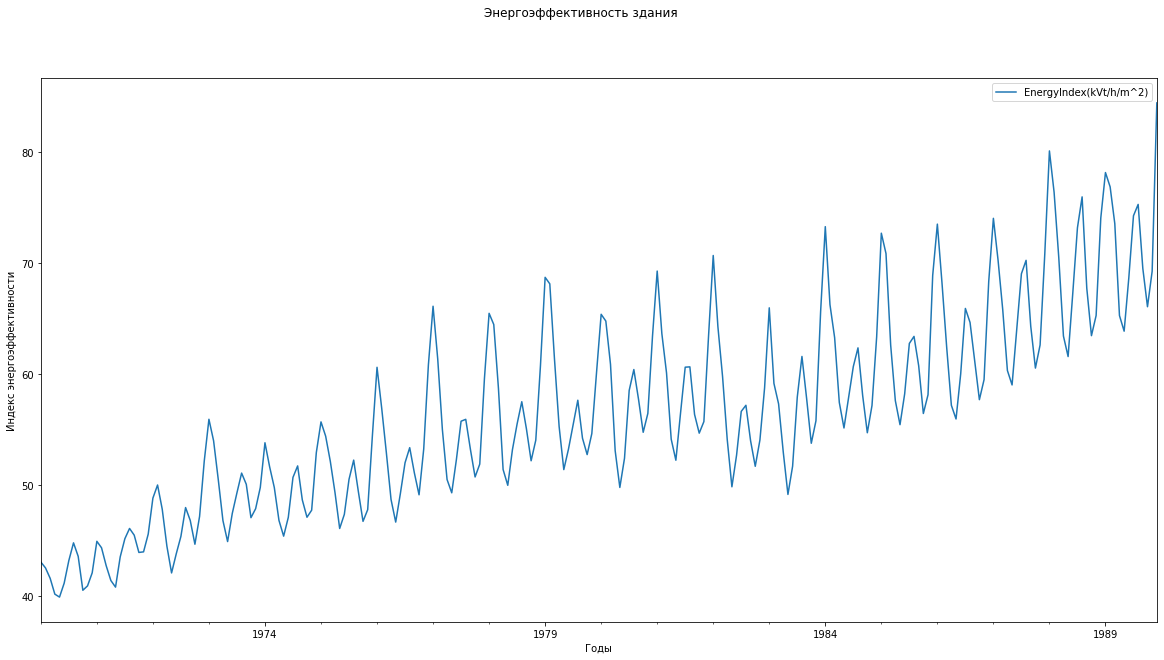

In [33]:
# построим общий график по нашим данным
df.scheme = df[['EnergyIndex(kVt/h/m^2)']].plot(subplots=True, figsize=(20, 10), title = 'Энергоэффективность здания', xlabel = 'Годы', ylabel = 'Индекс энергоэффективности')

**Вывод по 2 Этапу:** Индекс энергоэффективности растет с каждым годом, а это значит, что с течением времени требуется все больше энергии для отопления квадратного метра жилой площади. Также из графика видны логичные сезонные колебания - зимой затрачивается больше энергии на отопление, а летом незначительный скачок из-за потребления электричества кондиционерами для охлаждения помещений.

**Этап 3: Построение моделей, анализ результатов.**

In [35]:
# в качестве тестовой и обучающей выборок возьмем промежутки времени в 12 месяцев
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [36]:
# посмотрим на обучающую выборку
train.head()

,Date,EnergyIndex(kVt/h/m^2)
Date,,
1970-01-01,1970-01-01,43.0869
1970-02-01,1970-02-01,42.5577
1970-03-01,1970-03-01,41.6215
1970-04-01,1970-04-01,40.1982
1970-05-01,1970-05-01,39.9321


In [37]:
# а теперь посмотрим на тестовую выборку
test.head()

,Date,EnergyIndex(kVt/h/m^2)
Date,,
1989-01-01,1989-01-01,78.1368
1989-02-01,1989-02-01,76.8499
1989-03-01,1989-03-01,73.5377
1989-04-01,1989-04-01,65.2676
1989-05-01,1989-05-01,63.8617


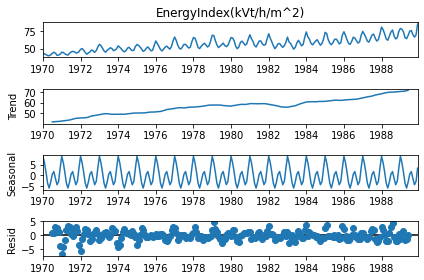

In [42]:
# построим аддитивную декомпозицию временного ряда 
r = seasonal_decompose(df['EnergyIndex(kVt/h/m^2)'], model='additive')
r.plot();

**Наблюдается годовая сезонность и положительный тренд.**


Задачи:

- описать модель
- подобрать оптимальные параметры
- создать модель
- обучить модель
- сделать прогноз на период тестовой выборки
- сравнить прогноз с тестовой выборкой (построить график)
- оценить качество прогноза
- сделать прогноз на будущее
- сделать выводы о работе данного метода прогнозирования



Модель 1: SARIMAX

In [44]:
# Вызываем pmdarima.auto_arima, чтобы получить набор параметров для модели
auto_arima(df['EnergyIndex(kVt/h/m^2)'],seasonal=True, m=12).summary() # включаем сезонность - 12 месяцев

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(3, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -413.258
Date:                            Thu, 24 Mar 2022   AIC                            840.516
Time:                                    17:25:02   BIC                            864.522
Sample:                                         0   HQIC                           850.202
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0475      0.046      1.044      0.296      -0.042       0.137
ar.L1          1.6309      0.166      9.805      0.000       1.305       1.957
ar.L2         -0.8740      0.155     -5.642      0.000      -1.178      -0.570
ar.L3          0.2157      0.091      2.377      0.017       0.038       0.394
ma.L1         -0.7386      0.174     -4.250      0.000      -1.079      -0.398
ma.S.L12      -0.5458      0.059     -9.263      0.000      -0.661      -0.430
sigma2         2.1500      0.148     14.511      0.000       1.860       2.440
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                64.01
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Мы получили модель с параметрами SARIMAX(3, 0, 1)x(0, 1, 1, 12)

In [45]:
# создаем модель с подобранными параметрами
model_sarimax = SARIMAX(train['EnergyIndex(kVt/h/m^2)'],order=(3, 0, 1), seasonal_order=(0, 1, 1, 12))

# обучаем модель на обучающей выборке данных
results_sarimax = model_sarimax.fit()

# получаем результаты
results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             EnergyIndex(kVt/h/m^2)   No. Observations:                  228
Model:             SARIMAX(3, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -381.946
Date:                            Thu, 24 Mar 2022   AIC                            775.892
Time:                                    17:27:51   BIC                            796.143
Sample:                                01-01-1970   HQIC                           784.074
                                     - 12-01-1988                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7157      0.101     16.925      0.000       1.517       1.914
ar.L2         -0.9492      0.111     -8.540      0.000      -1.167      -0.731
ar.L3          0.2298      0.084      2.735      0.006       0.065       0.394
ma.L1         -0.8008      0.098     -8.189      0.000      -0.993      -0.609
ma.S.L12      -0.5539      0.053    -10.372      0.000      -0.659      -0.449
sigma2         1.9570      0.171     11.424      0.000       1.621       2.293
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.06
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               1.79   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
# делаем предсказание по первому и последнему значению и оцениваем качество прогноза
start=len(train) # первая точка в тестовом множестве
end=len(train)+len(test)-1 # последняя точка в тестовом множестве

# предсказываем значения
predictions = results_sarimax.predict(start=start, end=end, dynamic=False, typ='levels').rename('Predictions SARIMAX(3, 0, 1)x(0, 1, 1, 12)')
predictions

1989-01-01    81.841535
1989-02-01    77.863364
1989-03-01    72.411590
1989-04-01    66.239556
1989-05-01    64.428837
1989-06-01    69.193109
1989-07-01    74.538147
1989-08-01    76.090983
1989-09-01    69.875231
1989-10-01    65.905134
1989-11-01    67.765266
1989-12-01    76.339476
Freq: MS, Name: Predictions SARIMAX(3, 0, 1)x(0, 1, 1, 12), dtype: float64

[Text(0, 0.5, 'Энергозатраты'), Text(0.5, 0, 'Месяц')]

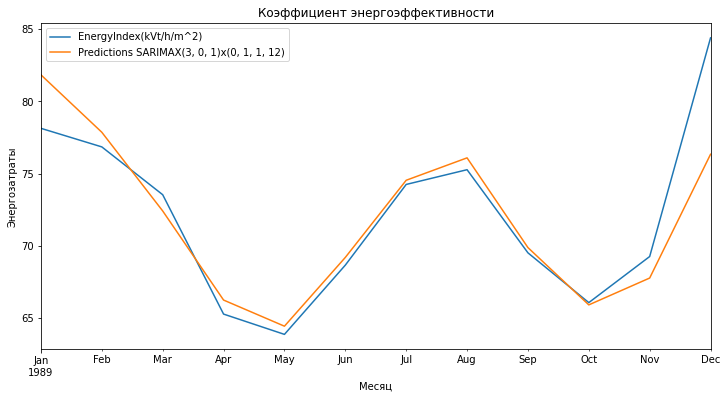

In [54]:
# сравним результаты прогноза и теста на графике
ax = test['EnergyIndex(kVt/h/m^2)'].plot(legend=True, figsize=(12,6),title='Коэффициент энергоэффективности') 
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel='Месяц', ylabel='Энергозатраты')

In [55]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['EnergyIndex(kVt/h/m^2)'], predictions)
mse_error = mean_squared_error(test['EnergyIndex(kVt/h/m^2)'], predictions)
rmse_error = rmse(test['EnergyIndex(kVt/h/m^2)'], predictions)
mape_error = np.mean(np.abs(predictions - test['EnergyIndex(kVt/h/m^2)'])/test['EnergyIndex(kVt/h/m^2)'])*100

print(f'SARIMAX(3, 0, 1)x(0, 1, 1, 12) MAE Error: {mae_error:11.10}')
print(f'SARIMAX(3, 0, 1)x(0, 1, 1, 12) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(3, 0, 1)x(0, 1, 1, 12) RMSE Error: {rmse_error:11.10}')
print(f'SARIMAX(3, 0, 1)x(0, 1, 1, 12) MAPE Error: {mape_error:11.10}')

SARIMAX(3, 0, 1)x(0, 1, 1, 12) MAE Error: 1.591966391
SARIMAX(3, 0, 1)x(0, 1, 1, 12) MSE Error: 7.145330733
SARIMAX(3, 0, 1)x(0, 1, 1, 12) RMSE Error: 2.673075145
SARIMAX(3, 0, 1)x(0, 1, 1, 12) MAPE Error: 2.057905478


In [56]:
#делаем прогноз на будущее - 1 год вперед

# обучаем модель на всем датасете
fut_model_sarimax = SARIMAX(df['EnergyIndex(kVt/h/m^2)'],order=(3, 0, 1), seasonal_order=(0, 1, 1, 12))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             EnergyIndex(kVt/h/m^2)   No. Observations:                  240
Model:             SARIMAX(3, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -415.510
Date:                            Thu, 24 Mar 2022   AIC                            843.021
Time:                                    18:10:38   BIC                            863.597
Sample:                                01-01-1970   HQIC                           851.322
                                     - 12-01-1989                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7509      0.094     18.681      0.000       1.567       1.935
ar.L2         -0.9646      0.117     -8.236      0.000      -1.194      -0.735
ar.L3          0.2119      0.084      2.523      0.012       0.047       0.377
ma.L1         -0.8439      0.084    -10.022      0.000      -1.009      -0.679
ma.S.L12      -0.5587      0.057     -9.876      0.000      -0.670      -0.448
sigma2         2.1795      0.153     14.279      0.000       1.880       2.479
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                49.80
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

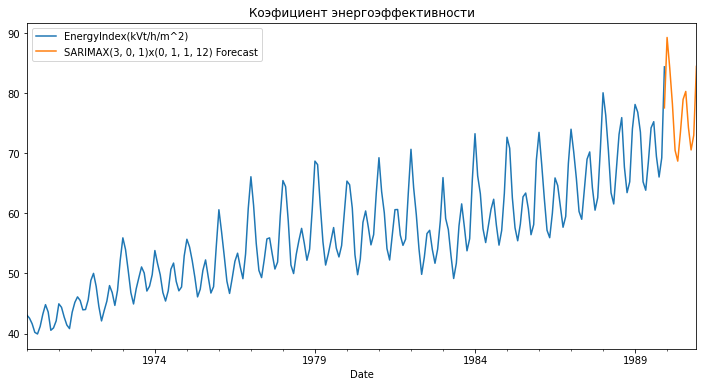

In [57]:
#задаем точки будущего
fut_fcast_sarimax = fut_results_sarimax.predict(len(df)-1,len(df)+11,typ='levels').rename('SARIMAX(3, 0, 1)x(0, 1, 1, 12) Forecast')

#строим график на будущее
ax = df['EnergyIndex(kVt/h/m^2)'].plot(legend=True, figsize=(12,6),title='Коэфициент энергоэффективности') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

**Выводы работы метода SARIMAX**
- Модель показала себя хорошо, RMSE=2.67 кВТ/ч/м2, это хороший показатель.
- Также процент рассчитанной ошибки MAPE=2%, это хороший результат.
- Согласно графику мы видим, что тренд и высота амплитуда были отображены корректно, общая динамика прослеживается.

Модель 2: PROPHET

In [59]:
# подготовим данные для модели
train_prophet = train[['Date','EnergyIndex(kVt/h/m^2)']]
test_prophet = test[['Date','EnergyIndex(kVt/h/m^2)']]

# переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet
train_prophet.columns = ['ds', 'y'] # переименовали столбцы
test_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [60]:
# подготовим данные по всему датасету для модели
df_prophet = df[['Date','EnergyIndex(kVt/h/m^2)']]
df_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [74]:
# создаем модель с подобранными параметрами
model = Prophet(seasonality_mode='multiplicative') # модель самостоятельно подбирает параметры

# обучаем модель на обучающей выборке данных
model.fit(train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Промежуточные выводы: Как видим, алгоритм сам нам подсказывает, что он проигнорировал, выбирая параметры.

- Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.

недельную сезонность (для недельной сезонности нам нужно иметь данные минимум за месяц, чтобы суметь использовать ее в модели) INFO:fbprophet:                                                                

- Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

дневную сезонность (дневная сезонность может использоваться в случае, если данные собираются по часам/минутам, в нашем случае данные представлены по месяцам).

Зато он обнаружил годовую сезонность и использовал его при настройке модели.

In [75]:
future = model.make_future_dataframe(periods=12, freq='MS')
future.tail(12) # выводим 12 строк с конца

,ds
228,1989-01-01
229,1989-02-01
230,1989-03-01
231,1989-04-01
232,1989-05-01
233,1989-06-01
234,1989-07-01
235,1989-08-01
236,1989-09-01
237,1989-10-01


In [77]:
# предсказываем значения по модели, доверительный интервал по умолчанию 95%
prediction = model.predict(future)
prediction.head() # возвращает много колонок

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1970-01-01,40.959871,45.216846,49.479202,40.959871,40.959871,0.159131,0.159131,0.159131,0.159131,0.159131,0.159131,0.0,0.0,0.0,47.477849
1,1970-02-01,41.149059,43.022751,47.553043,41.149059,41.149059,0.097331,0.097331,0.097331,0.097331,0.097331,0.097331,0.0,0.0,0.0,45.154154
2,1970-03-01,41.319938,40.019490,44.586239,41.319938,41.319938,0.021734,0.021734,0.021734,0.021734,0.021734,0.021734,0.0,0.0,0.0,42.218003
3,1970-04-01,41.509126,36.411020,41.080794,41.509126,41.509126,-0.064873,-0.064873,-0.064873,-0.064873,-0.064873,-0.064873,0.0,0.0,0.0,38.816304
4,1970-05-01,41.692211,34.921642,39.542727,41.692211,41.692211,-0.106384,-0.106384,-0.106384,-0.106384,-0.106384,-0.106384,0.0,0.0,0.0,37.256818


In [78]:
# устанавливаем индекс
prediction.index = prediction.ds
prediction.head() # проверим изменения

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
1970-01-01,1970-01-01,40.959871,45.216846,49.479202,40.959871,40.959871,0.159131,0.159131,0.159131,0.159131,0.159131,0.159131,0.0,0.0,0.0,47.477849
1970-02-01,1970-02-01,41.149059,43.022751,47.553043,41.149059,41.149059,0.097331,0.097331,0.097331,0.097331,0.097331,0.097331,0.0,0.0,0.0,45.154154
1970-03-01,1970-03-01,41.319938,40.019490,44.586239,41.319938,41.319938,0.021734,0.021734,0.021734,0.021734,0.021734,0.021734,0.0,0.0,0.0,42.218003
1970-04-01,1970-04-01,41.509126,36.411020,41.080794,41.509126,41.509126,-0.064873,-0.064873,-0.064873,-0.064873,-0.064873,-0.064873,0.0,0.0,0.0,38.816304
1970-05-01,1970-05-01,41.692211,34.921642,39.542727,41.692211,41.692211,-0.106384,-0.106384,-0.106384,-0.106384,-0.106384,-0.106384,0.0,0.0,0.0,37.256818


Основные поля в прогнозе следующие:

ds — дата прогноза

yhat — спрогнозированное значение

yhat_lower — нижняя граница доверительного интервала для прогноза

yhat_upper — верхняя граница доверительного интервала для прогноза



In [79]:
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12) # оставим только нужные

,ds,yhat,yhat_lower,yhat_upper
ds,,,,
1989-01-01,1989-01-01,81.225720,79.073536,83.470298
1989-02-01,1989-02-01,76.752900,74.546821,78.983557
1989-03-01,1989-03-01,72.030928,69.979596,74.230702
1989-04-01,1989-04-01,65.700236,63.406825,68.165261
1989-05-01,1989-05-01,63.098017,60.946220,65.276844
1989-06-01,1989-06-01,66.954429,64.766156,69.072953
1989-07-01,1989-07-01,71.709637,69.588070,73.869255
1989-08-01,1989-08-01,73.467137,71.204011,75.673697
1989-09-01,1989-09-01,69.235835,66.925822,71.448041


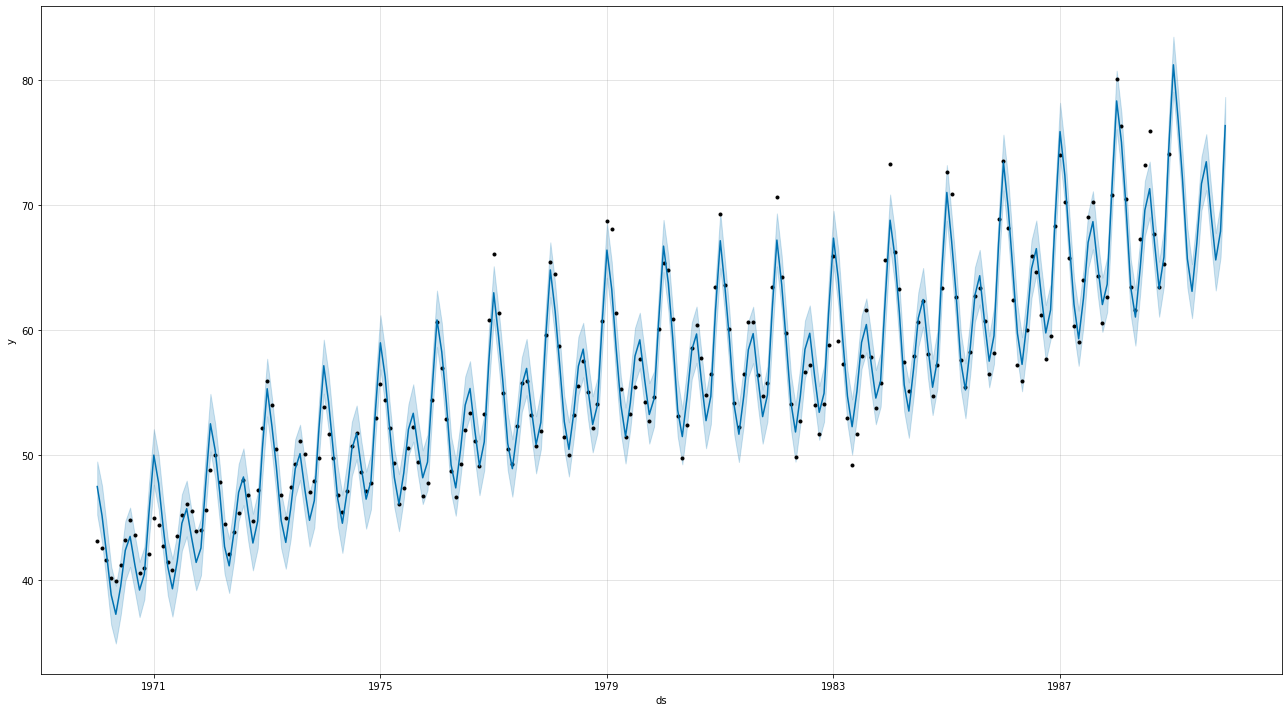

In [83]:
# при помощи .plot() прогноз можно построить на графике.

# Черные точки — наши данные.
model.plot(prediction, figsize=(18,10));

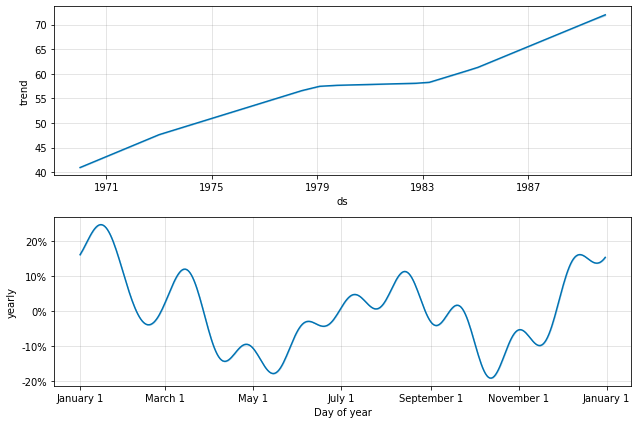

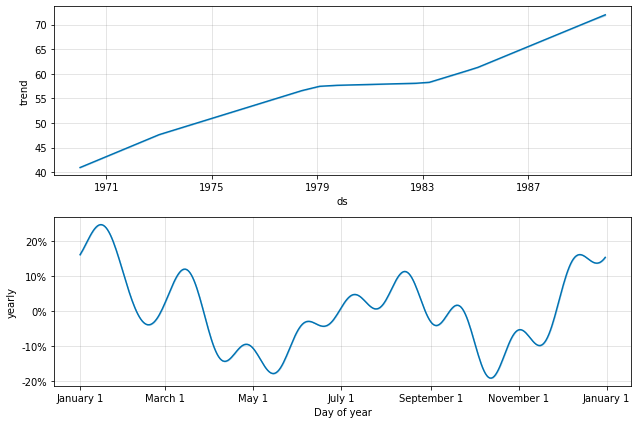

In [85]:
# plot_components() — возвращает несколько графиков, среди которых тренд и столько сезонностей, сколько он найдет.
model.plot_components(prediction)

Промежуточные выводы: Видим, что тренд энергоиндекса возрастающий и у нас есть годовая сезонность. Видим каким образом изменяется коэфициент по месяцам.

In [86]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test_prophet['y'], prediction['yhat'].tail(12))
mse_error = mean_squared_error(test_prophet['y'], prediction['yhat'].tail(12))
rmse_error = rmse(test_prophet['y'], prediction['yhat'].tail(12))
mape_error = np.mean(np.abs(prediction['yhat'] - test_prophet['y'])/test_prophet['y'])*100

print(f'Prophet MAE Error: {mae_error:11.10}')
print(f'Prophet MSE Error: {mse_error:11.10}')
print(f'Prophet RMSE Error: {rmse_error:11.10}')
print(f'Prophet MAPE Error: {mape_error:11.10}')

Prophet MAE Error: 1.838011803
Prophet MSE Error: 7.669972891
Prophet RMSE Error: 2.769471591
Prophet MAPE Error: 2.403566144


In [88]:
# делаем прогноз на будущее - 1 год вперед

# обучаем модель на всем датасете
fut_model_prophet = Prophet(seasonality_mode='additive')
fut_model_prophet.fit(df_prophet)

# говорим профету сделать дата-фрейм на 1 год вперед
fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=12)
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
# устанавливаем индекс
fut_fcast_prophet.index = fut_fcast_prophet.ds

In [90]:
# убедимся в изменениях
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
1970-01-01,1970-01-01,41.263279,46.844237,52.344822,41.263279,41.263279,8.388236,8.388236,8.388236,8.388236,8.388236,8.388236,0.0,0.0,0.0,49.651515
1970-02-01,1970-02-01,41.445642,44.125773,49.490613,41.445642,41.445642,5.294440,5.294440,5.294440,5.294440,5.294440,5.294440,0.0,0.0,0.0,46.740082
1970-03-01,1970-03-01,41.610357,40.203419,45.532240,41.610357,41.610357,1.189688,1.189688,1.189688,1.189688,1.189688,1.189688,0.0,0.0,0.0,42.800045
1970-04-01,1970-04-01,41.792720,35.519717,40.644569,41.792720,41.792720,-3.650106,-3.650106,-3.650106,-3.650106,-3.650106,-3.650106,0.0,0.0,0.0,38.142615
1970-05-01,1970-05-01,41.969200,33.395588,38.753319,41.969200,41.969200,-5.923175,-5.923175,-5.923175,-5.923175,-5.923175,-5.923175,0.0,0.0,0.0,36.046025


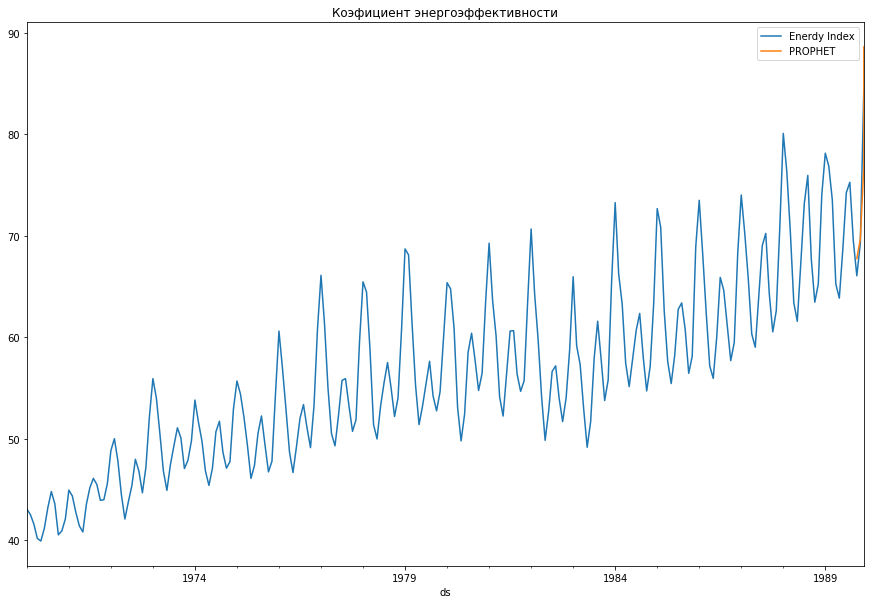

In [95]:
# строим график на будущее
ax = df_prophet['y'].plot(legend=True, figsize=(15,10),title='Коэфициент энергоэффективности') 
fut_fcast_prophet['yhat'].tail(15).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["Enerdy Index", "PROPHET"]);

**Выводы работы метода PROPHET:**
Модель показала себя хорошо, RMSE=2.7 кВт/ч/м2, это хороший показатель.
Процент рассчитанной ошибки MAPE=2,4%, это хороший результат, такому прогнозу можно доверять.

**Общие выводы:**
Проведен анализ данных с использованием современных методов обработки статистической информации.

Рассчитаны основные статистические метрики, позволяющие судить о характере исследуемого явления.

По результатам анализа представленных данных можно выявить зависимость коэфициента энергоэффективности от сезона года. Также можно смело утверждать, что с каждым годом коэфициент растет, а значит требуется все больше энергии для обеспечения комфортных температурных условий в здании - инфраструктура изнашевается. 

Сравнивая две модели прогноза, можно сделать вывод, что и SARIMAX, и PROPHET показали приблизительно равные значения RMSE (2.7 и 2.7) и MAPE (2% и 2.4%). Но SARIMAX выглядит предпочтительнее.